# Experimento 1 - Atualizado
***
- Conjunto de Dados: VinBigData
- Aplicando mudança de escala típica nas imagens

### Importação dos pacotes

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

### Pré-processamento nos dados

In [2]:
# lendo os dados de um arquivo csv
dataframe = pd.read_csv('/content/drive/MyDrive/vinbigdata/train.csv')
# criando uma coluna com os caminhos relativos as imagens
dataframe['image_path'] = '/content/drive/MyDrive/vinbigdata/train/' + dataframe.image_id + '.jpg'

In [3]:
print('total de imagens disponíveis:', str(len(set(dataframe['image_path']))))

total de imagens disponíveis: 15000


In [4]:
# visualizando os casos disponíveis
dataframe['class_name'].value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [5]:
# removendo os casos não relativos a distúrbios pulmonares
dataframe = dataframe[dataframe.class_name != 'Aortic enlargement']
dataframe = dataframe[dataframe.class_name != 'Cardiomegaly']
dataframe = dataframe[dataframe.class_name != 'Other lesion']

In [6]:
# visualizando os casos disponíveis
dataframe['class_name'].value_counts()

No finding            31818
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [7]:
# separando os casos rotulados como normais e anormais
normal_cases = dataframe[(dataframe.class_id == 14) & (dataframe.class_name == 'No finding')]
abnormal_cases = dataframe[(dataframe.class_id != 14) & (dataframe.class_name != 'No finding')]

print('total de dados após a filtração:', str(len(set(normal_cases['image_path'])) + len(set(abnormal_cases['image_path']))))

total de dados após a filtração: 13952


In [8]:
# removendo as imagens repetidas
normal_data = normal_cases[['image_path', 'class_name']].drop_duplicates(subset = 'image_path', )
abnormal_data = abnormal_cases[['image_path', 'class_name']].drop_duplicates(subset = 'image_path', )

# criando dataframes especifos com caminhos para as imagens e rótulos
#normal_data = pd.DataFrame(normal_path, columns = ['filepath', 'finding_labels'])
normal_data['target'] = 'normal'
#abnormal_data = pd.DataFrame(abnormal_path, columns = ['filepath', 'finding_labels'])
abnormal_data['target'] = 'abnormal'

In [9]:
print('quantidade de dados rotulados como normais:', len(normal_data))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 10606
quantidade de dados rotulados como anormais: 3346


In [10]:
# removendo 69% dos casos normais para balancear os dados
normal, _ = train_test_split(normal_data, test_size = 0.69, random_state = 42)

In [11]:
print('quantidade de dados rotulados como normais:', len(normal))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 3287
quantidade de dados rotulados como anormais: 3346


In [12]:
# concatenando os dataframes de casos normais e anormais
full_data = pd.concat([normal, abnormal_data])

In [13]:
# misturando todos os dados do dataframe e reiniciando os valores dos índices 
full_data = full_data.sample(frac = 1, axis = 0, random_state = 42).reset_index(drop=True)

In [14]:
# separando os dados de treinamento e de teste
train_df, test_df = train_test_split(full_data, stratify = full_data['target'],
                                     test_size = 0.2, random_state = 42)

In [15]:
# separando os dados de validação dos dados de treinamento
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'],
                                           test_size = 0.2, random_state = 42)

In [16]:
# visualizando a quantidade de dados
print('quantidade de imagens de treinamento:', len(train_df['image_path']))
print('quantidade de rótulos de treinamento:', len(train_df['class_name']))
print('quantidade de imagens de teste:', len(test_df['image_path']))
print('quantidade de rótulos de teste:', len(test_df['class_name']))
print('quantidade de imagens de validação:', len(validation_df['image_path']))
print('quantidade de rótulos de validação:', len(validation_df['class_name']))

quantidade de imagens de treinamento: 4244
quantidade de rótulos de treinamento: 4244
quantidade de imagens de teste: 1327
quantidade de rótulos de teste: 1327
quantidade de imagens de validação: 1062
quantidade de rótulos de validação: 1062


### Aplicando mudança de escala típica

In [17]:
# normalizando as imagens de treinamento e aplicando aumento de dados
image_generator = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 10, zoom_range = 0.2)

# criando o gerador de imagens de treinamento 
train_generator = image_generator.flow_from_dataframe(
                                                      dataframe = train_df,
                                                      directory = '',
                                                      x_col = 'image_path',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'categorical',
                                                      target_size = (256, 256))

# normalizando as imagens de teste e validação
test_datagen = ImageDataGenerator(rescale = 1./255.)

# criando o gerador de imagens de validação 
valid_generator = test_datagen.flow_from_dataframe(
                                                      dataframe = validation_df,
                                                      directory = '.', 
                                                      x_col = 'image_path',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'categorical',
                                                      target_size = (256, 256))

test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe = test_df, 
                                                  directory = '.',
                                                  x_col = 'image_path',
                                                  y_col = 'target',
                                                  batch_size = 32,
                                                  seed = 42,
                                                  shuffle = True,
                                                  class_mode = 'categorical',
                                                  target_size = (256, 256))

Found 4244 validated image filenames belonging to 2 classes.
Found 1062 validated image filenames belonging to 2 classes.
Found 1327 validated image filenames belonging to 2 classes.


In [18]:
# visualizando a ordem númerica das classes
train_generator.class_indices

{'abnormal': 0, 'normal': 1}

### Preparando a rede neural convolucional

In [19]:
# baixando os pesos treinados da rede inception
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-04-15 17:34:11--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.69.128, 173.194.79.128, 108.177.119.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  70.8MB/s    in 1.2s    

2021-04-15 17:34:13 (70.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [20]:
# referenciando o local em que os pesos estão armazenados
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# carregando a arquitetura inception pré-treinada
pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

# carregando os pesos treinados com outros dados 
pre_trained_model.load_weights(local_weights_file)

# obtendo a última camada como sendo a nomeada por 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

In [21]:
x = layers.GlobalAveragePooling2D()(last_output)
# adicionando uma camada densa com 512 neurônios
x = layers.Dense(units = 512, activation = tf.nn.relu)(x)     
# conecatando a rede uma camada com 128 neurônios e função de ativação relu
x = layers.Dense(units = 256, activation = tf.nn.relu)(x) 
# aplicando uma camada de dropout com uma taxa de 20% (normalização)
x = layers.Dropout(rate = 0.2)(x)      
# adicionando uma camada de saída com um neurônio e uma função de ativação sigmoide
x = layers.Dense  (units = 2, activation = tf.nn.softmax)(x)    

# conecatando as camadas definidas acima com a arquitetura inception
model = Model(pre_trained_model.input, x) 

# compilando a rede 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'categorical_crossentropy', 
              metrics = ['acc'])

In [22]:
# definindo as flags iniciais  
pre_trained_model.trainable = True
set_trainable = False

# para a arquitetura inception, a rede será retreinada a partir da camada 'mixed6'
for layer in pre_trained_model.layers:
    if layer.name == 'mixed6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
# definindo o caminho pelo qual os pesos serão armazenados 
filepath = "transferlearning_weights.hdf5"
# callback para salvar o melhor valor dos pesos em relação ao desempenho com os dados de validação 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [24]:
# definindo um array de callbacks
callbacks = [checkpoint]

In [25]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 4242 // 32, 
                              validation_data = valid_generator, validation_steps = 1062 // 32,
                              callbacks = callbacks, epochs = 10, use_multiprocessing = True,
                              workers = 8)

Epoch 1/10
132/132 [==============================] - 698s 5s/step - loss: 0.4000 - acc: 0.8157 - val_loss: 0.7504 - val_acc: 0.8144

Epoch 00001: val_acc improved from -inf to 0.81439, saving model to transferlearning_weights.hdf5
Epoch 2/10
132/132 [==============================] - 149s 1s/step - loss: 0.2110 - acc: 0.9118 - val_loss: 0.4625 - val_acc: 0.8778

Epoch 00002: val_acc improved from 0.81439 to 0.87784, saving model to transferlearning_weights.hdf5
Epoch 3/10
132/132 [==============================] - 147s 1s/step - loss: 0.1729 - acc: 0.9299 - val_loss: 1.0516 - val_acc: 0.8381

Epoch 00003: val_acc did not improve from 0.87784
Epoch 4/10
132/132 [==============================] - 147s 1s/step - loss: 0.1402 - acc: 0.9454 - val_loss: 0.3480 - val_acc: 0.9157

Epoch 00004: val_acc improved from 0.87784 to 0.91572, saving model to transferlearning_weights.hdf5
Epoch 5/10
132/132 [==============================] - 147s 1s/step - loss: 0.1221 - acc: 0.9513 - val_loss: 0.4580

### Salvando o modelo

In [26]:
# carregando o melhor peso obtido para o modelo
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

In [27]:
# salvando os dois modelos obtidos durante o treinamento
model.save('model1')
best_model.save('model2')

INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets


In [ ]:
# carregando o melhor modelo para realização de testes de desempenho
model = tf.keras.models.load_model('/content/drive/MyDrive/experimentos/v2.0-exp1-ds4/model2')

In [31]:
model.evaluate(test_generator)

42/42 [==============================] - 1336s 33s/step - loss: 0.5387 - acc: 0.9111


[0.5387473106384277, 0.911077618598938]

### Métricas de avaliação do modelo

In [32]:
# carregando os dados de teste
for i in range(0, 42):
  (x1, y1) = test_generator[i]
  if i == 0:
    x, y = x1, y1
  else:
    x = np.concatenate((x, x1))
    y = np.concatenate((y, y1))

In [33]:
# realizando a predição para os dados de teste
predict = model.predict(x)

In [34]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix

def thresholds(limiar, predict):
  '''predição para diferentes thresholds'''

  predict_ = []
  for i in predict:
    if i > limiar:
      predict_.append(1)
    else:
      predict_.append(0)
  
  return predict_

def precision_recall_accuracy_curve(predict, y):
  ''' Relaciona a curva da Precisão, Sensibilidade e Acurácia em relação a diferentes Thresholds'''

  limiares = np.arange(0, 1, 0.05)
  predicts = []
  precisions = []
  recalls = []
  accuracy = []
  flag = 0
  for i in limiares:
    predicts.append(thresholds(i, predict))
    precisions.append(precision_score(predicts[flag], y))
    recalls.append(recall_score(predicts[flag], y))
    accuracy.append(accuracy_score(predicts[flag], y))
    flag += 1
  
  return precisions, recalls, accuracy

def plot_precision_recall_accuracy_curve(precisions, recalls, accuracy):
  '''Plotando a curva de Precisão, Sensibilidade e Acurácia'''

  plt.figure(figsize = (10,5))
  plt.plot(np.arange(0, 1, 0.05), precisions, label = 'Precision')
  plt.plot(np.arange(0, 1, 0.05), recalls, label = 'Recall')
  plt.plot(np.arange(0, 1, 0.05), accuracy, label = 'Accuracy')
  plt.title('Precisão, Sensibilidade e Acurácia para diferentes Thresholds')
  plt.xlabel('Thresholds')
  plt.legend()
  plt.savefig('curve-analysis')

  return None

def best_metrics(threshold, predict, y):
  '''Melhores valores para o threshold escolhido'''

  predict_ = thresholds(threshold, predict)
  print('Matriz de Confusão:\n', confusion_matrix(predict_, y))
  print('Acurácia:', accuracy_score(predict_, y))
  print('Precisão', precision_score(predict_, y))
  print('Sensibilidade:', recall_score(predict_, y)) 
  print('F1_Score:', f1_score(predict_, y))

  return None

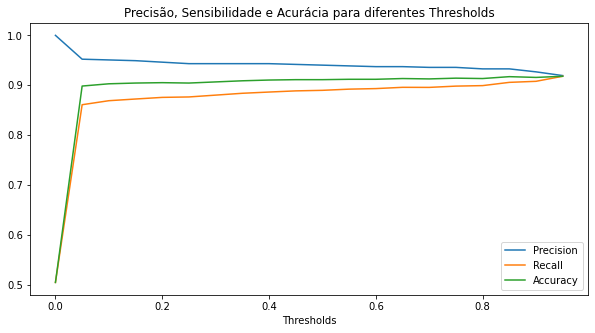

In [35]:
# plotando a curva da Precisão, Sensibilidade e Acurácia 
precisions, recalls, accuracy = precision_recall_accuracy_curve(predict[:,0], y[:,0])
plot_precision_recall_accuracy_curve(precisions, recalls, accuracy)

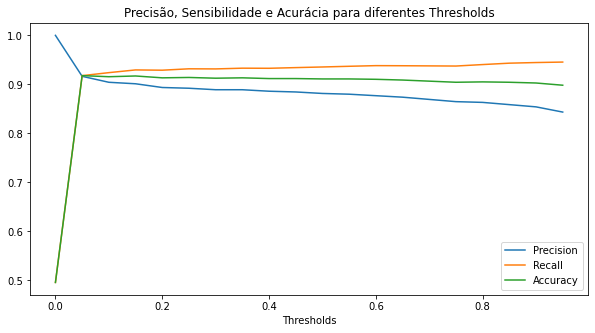

In [36]:
# plotando a curva da Precisão, Sensibilidade e Acurácia 
precisions, recalls, accuracy = precision_recall_accuracy_curve(predict[:,1], y[:,1])
plot_precision_recall_accuracy_curve(precisions, recalls, accuracy)

In [39]:
# analisando as melhores métricas encontradas para o modelo
best_metrics(threshold = 0.60, predict = predict[:,0], y = y[:,0])

Matriz de Confusão:
 [[583  42]
 [ 75 627]]
Acurácia: 0.9118311981914092
Precisão 0.9372197309417041
Sensibilidade: 0.8931623931623932
F1_Score: 0.9146608315098469


In [40]:
# analisando as melhores métricas encontradas para o modelo
best_metrics(threshold = 0.60, predict = predict[:,1], y = y[:,1])

Matriz de Confusão:
 [[631  81]
 [ 38 577]]
Acurácia: 0.9103240391861341
Precisão 0.8768996960486323
Sensibilidade: 0.9382113821138212
F1_Score: 0.9065200314218383


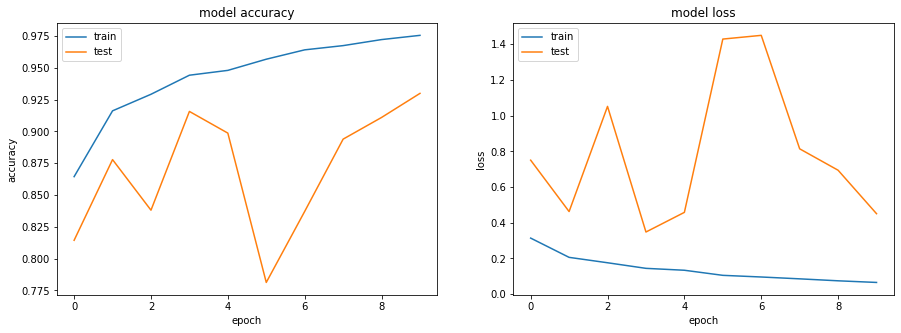

In [41]:
# visualizando o ganho de acurácia durante o treinamento
plt.figure(figsize = (15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model-accuracy')

# visualizando o decaimento da função de custo durante o treinamento 
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model-loss')

### Algoritmo Grad Cam

In [43]:
import urllib.request as url

link = 'https://raw.githubusercontent.com/Alyssonmach/class-activation-maps/main/assets/grad_cam.py'
file_ = 'grad_cam.py'
url.urlretrieve(link, file_)

from grad_cam import get_img_array, make_gradcam_heatmap, save_and_display_gradcam

In [57]:
# tamanho padrão das imagens do modelo
img_size = (256, 256)
# importando os parâmetros de pré-processamento da rede
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
# definindo a última camada da rede a ser considerada
last_conv_layer = 'mixed7'
model_builder = model
# removendo a função de ativação da última camada
model_builder.layers[-1].activation = None

Classe prevista: [1. 0.]


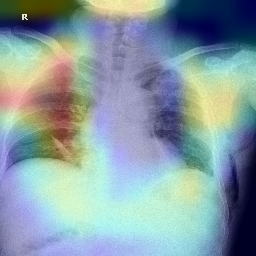

In [81]:
img, lbl = x[0], y[0]

img_path = tf.keras.preprocessing.image.array_to_img(img)

# preparando a imagem
img_array = preprocess_input(get_img_array(img_path, img_size))

# obtendo a predição do modelo
preds = model_builder.predict(img_array)
print('Classe prevista: {}'.format(lbl))

# gerando o mapa de ativação de classe (Grad-Cam)
heatmap = make_gradcam_heatmap(img_array, model_builder, last_conv_layer,
                               pred_index = 0)

# resultado final do algoritmo Grad-Cam
heatmap = save_and_display_gradcam(img_path, heatmap, cam_path = 'image1.png')

Classe prevista: [1. 0.]


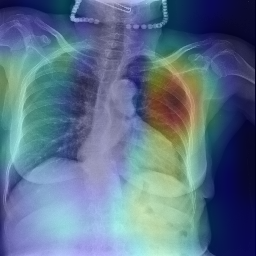

In [80]:
img, lbl = x[5], y[5]

img_path = tf.keras.preprocessing.image.array_to_img(img)

# preparando a imagem
img_array = preprocess_input(get_img_array(img_path, img_size))

# obtendo a predição do modelo
preds = model_builder.predict(img_array)
print('Classe prevista: {}'.format(lbl))

# gerando o mapa de ativação de classe (Grad-Cam)
heatmap = make_gradcam_heatmap(img_array, model_builder, last_conv_layer,
                               pred_index = 0)

# resultado final do algoritmo Grad-Cam
heatmap = save_and_display_gradcam(img_path, heatmap, cam_path = 'image2.png')

Classe prevista: [1. 0.]


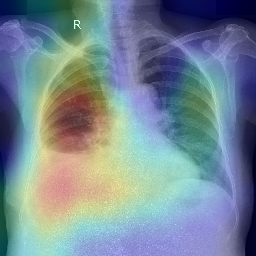

In [79]:
img, lbl = x[6], y[6]

img_path = tf.keras.preprocessing.image.array_to_img(img)

# preparando a imagem
img_array = preprocess_input(get_img_array(img_path, img_size))

# obtendo a predição do modelo
preds = model_builder.predict(img_array)
print('Classe prevista: {}'.format(lbl))

# gerando o mapa de ativação de classe (Grad-Cam)
heatmap = make_gradcam_heatmap(img_array, model_builder, last_conv_layer,
                               pred_index = 0)

# resultado final do algoritmo Grad-Cam
heatmap = save_and_display_gradcam(img_path, heatmap, cam_path = 'image3.png')

Classe prevista: [1. 0.]


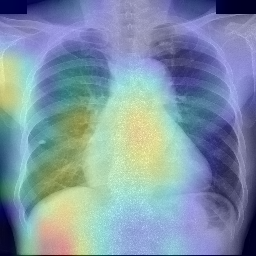

In [78]:
img, lbl = x[56], y[56]

img_path = tf.keras.preprocessing.image.array_to_img(img)

# preparando a imagem
img_array = preprocess_input(get_img_array(img_path, img_size))

# obtendo a predição do modelo
preds = model_builder.predict(img_array)
print('Classe prevista: {}'.format(lbl))

# gerando o mapa de ativação de classe (Grad-Cam)
heatmap = make_gradcam_heatmap(img_array, model_builder, last_conv_layer,
                               pred_index = 0)

# resultado final do algoritmo Grad-Cam
heatmap = save_and_display_gradcam(img_path, heatmap, cam_path = 'image4.png')

### Visualizando a arquitetura do modelo

In [77]:
# visualizando a arquitetura do modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________